## Kaggle Digit Recognizer

This tutorial will demonstrate how to use Convolutional Neural Networks (CNNs) to identify hand-written digits (0-9) from the MNIST dataset. This should provide a simple introduction to Image Classification that will be useful for any Kaggle beginners. In this notebook I will be using the MNIST dataset from Kaggle, not from keras.datasets.

There are 4 simple steps for CNN:

1. Loading and preprocessing (rescaling) images

2. Split into train/validation(test set) 

3. Design CNN model

4. Training model (+Img augmentation) for specified num. of epochs/batch size

In [74]:
## Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import matplotlib.style as style
import cv2
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#style.available
style.use('fivethirtyeight')

### 1. Loading and preprocessing (rescaling) images

(1) Load train dataset - We will load test.csv later to submit predictions using the final model

In [75]:
train = pd.read_csv('../input/train.csv')

In [76]:
## labels : target variables -> 0 - 9 
## num_classes : number of unique labels -> 10
## y_train : Converts a class vector (integers) to binary class matrix
labels = train.label
num_classes = len(np.unique(labels))
y = np_utils.to_categorical(labels, num_classes)

(1).a Very simple visualization

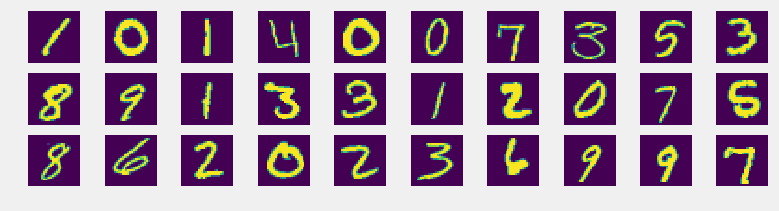

In [78]:
plt.figure(figsize=(12,3))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.axis('off')
    plt.imshow(train.values[i][1:].reshape(28,28))

(2).b. Very simple countplot

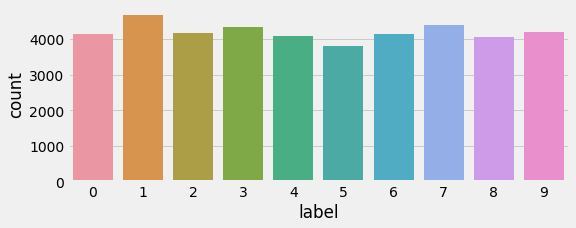

In [86]:
plt.figure(figsize=(8,3))
sns.countplot(x="label", data=train)

(2) Reshape the training dataset into tensor into (n_row, 28, 28, 1). Note that this dataset was originally stored as 784-element vectors, 
for each sample, not 28 x 28 matrices. We reshape each sample into
this tensor format, including 28 x 28 and number of channels.
Here, number of channels is 1 because this is not RGB color image.

In [16]:
## Drop labels from training set
train_features = train.drop('label',axis=1)
train_tensors = train_features.values.reshape(
                    train_features.shape[0],28,28,1).astype('float32')/255

Done! Easy! huh?


### 2. Split into train/validation/test dataset

StratifiedSplit helps retain the same proportion of the classes in both splits (train 80% / validation 20%).

In [7]:
strati = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_idx, val_idx in strati.split(train_tensors, y):
    train_tensors, valid_tensors = train_tensors[train_idx], train_tensors[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]

### 3. Design CNN Architecture

This is an important part! I designed my own CNN Architecture, using Convolution, Pooling and dropout layers. You can change any specific parameters and layers if you want.

In [8]:
## Design Model===================================================
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=2, activation='relu',
               input_shape=train_tensors.shape[1:]))
model.add(Conv2D(filters=32,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128,kernel_size=2, activation='relu'))
model.add(Conv2D(filters=128,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))
#=================================================================

### 4.  Training model

There are several hyper parameters for this step, but here I will focus on the followings.

(1) model.compile 
- optimizer

(2) Image Augmentation
- horizontal flip/vertical flip
- width_shift_range/height_shift_range
- zoom_range/shear_range
- rotation_range

(3) Fitting model 
- batch_size
- epochs

In [7]:
## Compile model with a optimizer (RMS) and accuracy as the metric
model.compile(optimizer=RMSprop(lr=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## We'll use EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau.
checkpointer = [EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
                ModelCheckpoint(filepath='weights.hdf5', 
                            monitor='val_loss', save_best_only=True, 
                            verbose=0),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                              patience=2, verbose=0, 
                              mode='auto',  cooldown=0, min_lr=0)]

## We'll use Image Augmentation
datagen =ImageDataGenerator(rotation_range=8, 
                            width_shift_range=0.1, 
                            shear_range=0.3,
                            height_shift_range=0.1, 
                            zoom_range=0.1)

## Train the model with epochs=20, batch_size=64
batch_size=64
epochs=20
final = model.fit_generator(datagen.flow(train_tensors, y_train, batch_size=batch_size),
            steps_per_epoch=len(train_tensors)/batch_size, 
            validation_data=datagen.flow(valid_tensors, y_valid, batch_size=batch_size), 
            validation_steps=len(valid_tensors)/batch_size,
            callbacks=checkpointer,
            epochs=epochs, 
            verbose=1)

Epoch 1/20
525/525 [==============================] - 95s 181ms/step - loss: 0.6357 - acc: 0.7877 - val_loss: 0.3685 - val_acc: 0.8900
Epoch 2/20
525/525 [==============================] - 88s 168ms/step - loss: 0.2255 - acc: 0.9332 - val_loss: 0.1266 - val_acc: 0.9619
Epoch 3/20
525/525 [==============================] - 88s 168ms/step - loss: 0.1643 - acc: 0.9520 - val_loss: 0.1492 - val_acc: 0.9588
Epoch 4/20
525/525 [==============================] - 87s 167ms/step - loss: 0.1431 - acc: 0.9588 - val_loss: 0.1502 - val_acc: 0.9557
Epoch 5/20
525/525 [==============================] - 88s 167ms/step - loss: 0.0866 - acc: 0.9742 - val_loss: 0.0725 - val_acc: 0.9783
Epoch 6/20
525/525 [==============================] - 88s 168ms/step - loss: 0.0773 - acc: 0.9772 - val_loss: 0.0663 - val_acc: 0.9788
Epoch 7/20
525/525 [==============================] - 87s 166ms/step - loss: 0.0740 - acc: 0.9788 - val_loss: 0.0744 - val_acc: 0.9783
Epoch 8/20
525/525 [==============================] - 8

Done!!!!

### 5. Result

In [8]:
def plot_lc(model_history):
    n = len(model_history.history['acc'])
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)

    ax1.plot(range(1,n+1),model_history.history['acc'])
    ax1.plot(range(1,n+1),model_history.history['val_acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    ax1.set_xticks(np.arange(1,n+1),n/10)
    ax1.legend(['train', 'val'], loc='best')

    ax2 = fig.add_subplot(122)
    ax2.plot(range(1,n+1),model_history.history['loss'])
    ax2.plot(range(1,n+1),model_history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    ax2.set_xticks(np.arange(1,n+1),n/10)
    ax2.legend(['train', 'val'], loc='best')
    plt.show()

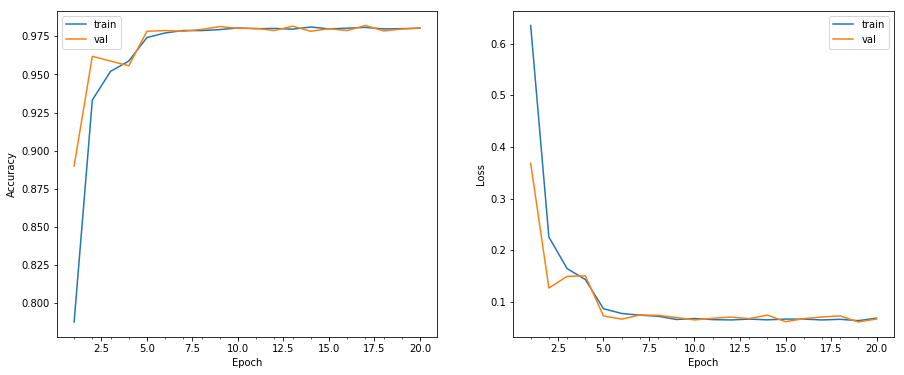

In [9]:
plot_lc(final)

In [10]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0)))
             for feature in test_tensors]
true_class = np.argmax(y_test, axis=1)
num_correct = np.sum(predictions == true_class) 
accuracy = float(num_correct)/result.shape[0]
print(accuracy)

0.9883333333333333


In [10]:
def plot_confusion(pltname,predictions,test_list):
    ## Check a confusion matrix with the result using test dataset.
    confusion = confusion_matrix(test_list,predictions)
    ## Plot Confusion Matrix
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax = sns.heatmap(confusion, ax=ax, cmap=plt.cm.Oranges, annot=True,fmt='3d')
#    ax.set_xticklabels(range(10))
#    ax.set_yticklabels(range(10))
    plt.title('Confusion Matrix',size=20)
    plt.ylabel('True',size=16)
    plt.xlabel('Predicted',size=16)
    plt.savefig(pltname,dpi=150)

In [11]:
plot_confusion('confusion.png',predictions,true_class)

NameError: name 'predictions' is not defined

### 6. Save a df file to submit the result to fit the model with test data in Kaggle

In [14]:
test = pd.read_csv('../input/test.csv')
test_tensors = test.values.reshape(
                    test.shape[0],28,28,1).astype('float32')/255

result = model.predict(test_tensors)
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0)))
             for feature in test_tensors]

In [29]:
submission = pd.DataFrame({ 'ImageId': test.index.values+1,
                            'Label': predictions })
submission.to_csv("submission.csv",index=False)